# SECS implementation i Python

Create a figure illustrating Python implementation spherical elementary current system (SECS) analysis on a cubed sphere grid (Figure 4 in paper).

Import relevant modules:

In [1]:
%matplotlib inline
import lompe
import numpy as np
import pandas as pd
import datetime as dt
import apexpy
import matplotlib.pyplot as plt
from lompe.secsy import get_SECS_B_G_matrices

Re = 6371.2e3    # Earth radius
HI = 110e3       # Ionospheric altitude
time = dt.datetime(2005, 9, 10)

Set up cubed sphere (CS) projection and grid. Note that we are working in magnetic coordinates (mlat, mlon) in this example. (NB: For Lompe, the grid must be set up in geographic coordinates.)

In [2]:
L, W, Lres, Wres = 20000e3, 20000e3, 100e3, 100e3
projection = lompe.cs.CSprojection(position = (0, 90), orientation = 0)
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R = Re+HI) # set grid to ionospheric altitude

We can visualize by plotting grid and coastlines (using the helper function to get $\xi, \eta$ coastlines for magnetic coordinates):

In [3]:
def get_mag_coastlines(proj, apex, height = 110):
    """ get coastlines in xi, eta for a grid defined in magnetic longitude and latitude """
    import cartopy.io.shapereader as shpreader
    shpfilename = shpreader.natural_earth(resolution='50m', category='physical', name='coastline')
    reader = shpreader.Reader(shpfilename)
    coastlines = reader.records()
    multilinestrings = []
    for coastline in coastlines:
        if coastline.geometry.geom_type == 'MultiLineString':
            multilinestrings.append(coastline.geometry)
            continue
        lon, lat = np.array(coastline.geometry.coords[:]).T
        mlat, mlon = a.geo2apex(lat, lon, height) # geographic -> magnetic
        yield proj.geo2cube(mlon, mlat)

    for mls in multilinestrings:
        for ls in mls:
            lon, lat = np.array(ls.coords[:]).T
            mlat, mlon = a.geo2apex(lat, lon, height) # geographic -> magnetic
            yield proj.geo2cube(mlon, mlat)


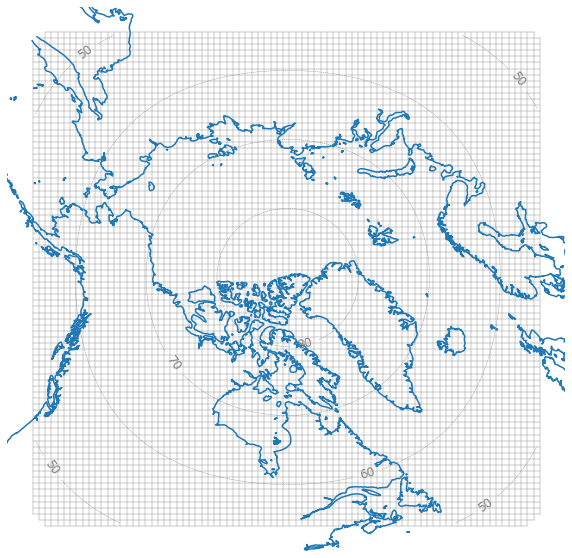

In [4]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_axis_off()

# grid
a = apexpy.Apex(time, refh=HI*1e-3) # reference altitude in km
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()

# coastlines
a = apexpy.Apex(time, refh=HI*1e-3) # reference altitude in km
for cl in get_mag_coastlines(grid.projection, a):
    ax.plot(cl[0], cl[1], color = 'C0')

# add (geographic) latitude contours
co = ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
ax.clabel(co, co.levels, inline = True, fontsize = 12)

ax.set_xlim(xlim)
ax.set_ylim(ylim);

For this example, we chooe to set the Pedersen $\Sigma_P$ and Hall $\Sigma_H$ conductances to a constant $10\ \mathrm{moh}$ across the entire grid:

In [5]:
SH = np.ones(grid.shape)*10 # moh
SP = np.ones(grid.shape)*10 # moh

This assumption is the basis of how we can relate the ionospheric electric potential to magnetic field perturbations on ground.

In notebook 01, we calculated the divergence of the ionospheric electric field $\nabla\cdot\mathbf{E}$ from a [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model potential $\Phi$. We want to use this divergence to represent FACs, $j_{||}$. We have conductances that are constant across the grid, and therefore no gradients of the Pedersen and Hall conductance. Thus the FACs and $\nabla\cdot\mathbf{E}$ can be related through ([Reistad et al. 2019](https://doi.org/10.1029/2019JA026634))

\begin{equation*}
    j_{||} = \Sigma_P\nabla\cdot\mathbf{E}
\end{equation*}


NOTE: This is derived from taking the divergence of the (horizontal) ionospheric current density $\nabla\cdot\mathbf(J)_{\perp}$ from the height-integrated Ohm's law, $\mathbf{J}_{\perp}=\Sigma_P\mathbf{E}+\Sigma_H\hat{\mathbf{b}}\times\mathbf{E}$. The use of the ionospheric Ohm's law implies steady-state, and $\nabla\times\mathbf{E}=0$.

We load the $\nabla\cdot\mathbf{E}$ from the file saved from notebook 01 (note that the grid in notebook 01 is identical to the cubed sphere grid in this example):

In [6]:
# load div(E)
df = pd.read_hdf('./datasets/01divE.h5')
divE = (df['divE'].values).reshape(grid.shape)

# calculate FACs
FAC = divE*SH

FACs are related to curl-free (CF) amplitudes of SECS basis functions for the current densities (unit: Ampere), $\mathbf{S}^{\star}$:
\begin{equation*}
    \mathbf{S}^{\star}=j_{||}\cdot A
\end{equation*}

In [7]:
CF_amp = FAC*grid.A

As there are no conductance gradients along the electric field, and the Hall-to-Pedersen conductance ratio is a constant, the CF amplitudes and divergence-free (DF) SECS amplitudes $\mathbf{S}^{\circ}$ are related through:
\begin{equation}
    j_{||}=-\frac{1}{\alpha}\left(\nabla\times\mathbf{J}^{\circ}\right)_r
\end{equation}
where $\mathbf{J}$ is the horizontal current (Equation 5 in [Amm et al. 2002](https://doi.org/10.1029/2002JA009472)). The Hall-to-Pedersen conductance ratio is $\Sigma_H/\Sigma_P=1$, and the field-aligned currents ($j_{||}=\nabla\cdot\mathbf{J}$) are inversely proportional to the radial component of the curl of the DF part of the horizontal currents $\mathbf{J}$.

We can therefore obtain $\mathbf{S}^{\circ}=-\mathbf{S}^{\star}$:

In [8]:
DF_amp = -CF_amp

The DF current are what can be observed as magnetic disturbances on ground $\Delta\tilde{\mathbf{B}}_g$, and we relate $\mathbf{S}^{\circ}$ to these disturbances through:
\begin{equation*}
    \Delta\tilde{\mathbf{B}}_g=\mathbb{H}^{\circ}_g\mathbf{S}^{\circ}
\end{equation*}

We use the vectorized implementation of the SECS basis functions to find the matrix $\mathbb{H}^{\circ}_g$ that relates the divergence-free amplitudes to the magnetic field on ground. $\mathbb{H}^{\circ}_g$ has elements from Equations~10-12 in the Lompe paper ([Laundal et al. 2022](https://doi.org/10.1029/2022JA030356)).

In [9]:
# limit for singularity correction is half a grid cell
secs_singularity_limit = np.min([grid.Wres, grid.Lres])/2

He_mat, Hn_mat, Hu_mat = get_SECS_B_G_matrices(np.ravel(grid.lat_mesh), np.ravel(grid.lon_mesh), grid.R, 
                                               np.ravel(grid.lat), np.ravel(grid.lon), RI = grid.R,
                                               current_type = 'divergence_free', 
                                               singularity_limit = secs_singularity_limit)

We set radius of evaluation points to be slightly offset from the grid centers to further mitigate the singularity-problem of the SECS basis functions, and specify where the altitude of the SECS amplitudes.

We can then calculate the magntic field disturbances on ground resulting from the FACs calculated from the Weimer potential:

In [10]:
Bge, Bgn, Bgu = He_mat.dot(DF_amp.flatten()), Hn_mat.dot(DF_amp.flatten()), Hu_mat.dot(DF_amp.flatten())

We can visualize the ground magnetic field using the implemented plotting functions fro visualization:

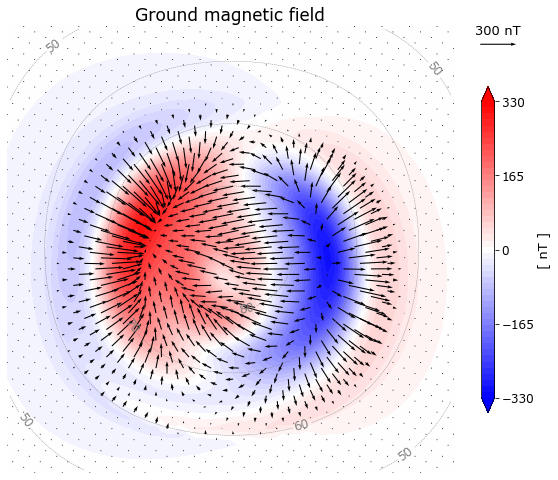

In [17]:
# set up figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('Ground magnetic field', fontsize = 17)
ax.set_aspect('equal')
ax.axis('off')

# magnetic latitude contours
c = ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', 
                                                linewidths = .4, levels = np.r_[-80:81:10])
ax.clabel(c, c.levels, inline = True, fontsize = 12)
    
# define some scales
scale = 600 * 1e-9 # ground magnetic field scale [T]
colorscale = np.linspace(-330, 330, 50) # upward component
ticks = np.linspace(-330, 330, 5) # upward component
scale_units = 'inches' # horizontal component

# transform horizontal components from (east, north) to CS (xi,eta) system
lo, la = grid.projection.cube2geo(grid.xi_mesh, grid.eta_mesh)
x, y, Ax, Ay = grid.projection.vector_cube_projection(Bge.reshape(lo.shape), Bgn.reshape(lo.shape), lo, la)

# plot vectors for every fifth evaluation location
q=ax.quiver(x[::5], y[::5], Ax[::5], Ay[::5], scale = scale, scale_units=scale_units, color='black')
ax.quiverkey(q, 1.1, .96, U=scale/2, label='300 nT', fontproperties={'size':13}) # add scale of vectors

# plot upward component and colorbar
Bgu = Bgu.reshape(grid.eta_mesh.shape)
c=ax.contourf(grid.xi_mesh, grid.eta_mesh, Bgu*1e9, cmap=plt.cm.bwr, levels=colorscale, zorder=0, extend='both')
cbar=fig.colorbar(c, ax=ax, ticks=ticks, orientation='vertical', shrink=0.6, aspect=25)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('[ nT ]', fontsize=13)

# save figure
fig.savefig('./output_figures/SECSexample.pdf')
fig.savefig('./output_figures/SECSexample.png')

The figure shows the ground magnetic field disturbances resulting from an ionosphere with the electric potential as the [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model. 

The color scale is the upward component (blue is downlard, red is upward), and the arrows show the horizontal components of the magnetic disturbance on ground. 

Note that this is the same way the ground magnetic field perturbations are illustrated in lompeplot. 